In [23]:
import torch
import torch.nn as nn
import math
from PIL import Image
import numpy as np
import torch.nn.functional as F
from cutmix.utils import onehot, rand_bbox
from torchvision import transforms
import random
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import matplotlib.image as img
import time
from sklearn.metrics import mean_squared_error
import seaborn as sns
from network.mynn import initialize_weights, Norm2d, Norm1d

from imresize import imresize
from dataset import CutBlurClimateDataset
from cutmix.utils import onehot, rand_bbox
import cv2

In [24]:
def random_crop():
    r_seed = np.random.randint(1,1e9)
    c_size = np.random.randint(32,100)
    random.seed(r_seed)
    t = transforms.RandomCrop(size=(c_size, c_size)) # can be different for H and W
    return r_seed, t

In [88]:
def generate_hr_lr(hr_sample, scale_factor):
    if isinstance(hr_sample, np.ndarray):
        print(hr_sample.shape)
        hr_sample = torch.from_numpy(hr_sample).to(torch.float32)
    
    lr_father = F.interpolate(hr_sample, scale_factor = (1./scale_factor), mode= 'bicubic') #downsize original: this is supposed to be the original input
    lr_father = F.interpolate(lr_father, (hr_sample.shape[2], hr_sample.shape[3]), mode= 'bicubic') #upsize father to original (the size ot whihc we want to interpolate) size
    lr_son = F.interpolate(lr_father, scale_factor = (1./scale_factor), mode= 'bicubic') #downsize upsized father
    lr_sample = F.interpolate(lr_son, (lr_father.shape[2], lr_father.shape[3]), mode= 'bicubic') #.squeeze(0) #upsize son; interpolate LR son to LR father, whihc now becomes a LR sample to be used
    hr_sample = lr_father.to(torch.float32) #.squeeze(0) #LR father now becomes the HR sample to be used
    
    return lr_sample, hr_sample

In [132]:
class HRClimateDataset(Dataset):
    """Use it for downscaling for ZSSR type low resolution dataset."""
    def __init__(self, lr_dir=None, hr_dir=None, transform=None, crop = True):
        self.hr_data = np.load(hr_dir)
#         self.hr_data = hr_dir
        self.transform = transform

    def __len__(self):
        return len(self.hr_data)

    def __getitem__(self, idx):
        hr_sample  = self.hr_data[idx] # (213, 321, 3)
        hr_sample = hr_sample.transpose((2, 0, 1)) # (3, 213, 321)
        hr_sample = torch.from_numpy(hr_sample).to(torch.float32)
        return hr_sample

class ZSSRTypeDataset(Dataset):
    """Use it for downscaling for ZSSR type low resolution dataset."""
    def __init__(self, dataset, scale_factor = 2., transform=None, crop=True, data_aug=True):
        
        self.hr_data = dataset
        self.transform = transform
        self.data_aug = data_aug
        self.scale_factor = scale_factor
        self.crop = crop

    def __len__(self):
        return len(self.hr_data)

    def __getitem__(self, idx):
        hr_sample  = self.hr_data 

        hr_sample = hr_sample.unsqueeze(0)

        if self.transform:
            hr_sample = self.transform(hr_sample)
        
        if self.data_aug:
            aug_imgs_lr = dict()
            aug_imgs_hr = dict()
            for k in range(0, 4):
#                 rot = np.rot90(hr_sample, k=k, axes = (1,2))
                rot = torch.rot90(hr_sample, k=k, dims = [2,3])
#                 flip = np.flip(rot, axis = 2)
                flip = torch.flip(rot, dims = [3])
                
                assert (rot.shape[0] == hr_sample.shape[0])
                
                lr_sample_rot, hr_sample_rot = generate_hr_lr(rot, self.scale_factor)
                lr_sample_flip, hr_sample_flip = generate_hr_lr(flip, self.scale_factor)
                aug_imgs_lr[f"rot{90*k}"] = lr_sample_rot
                aug_imgs_lr[f"flip{90*k}"] = lr_sample_flip
                aug_imgs_hr[f"rot{90*k}"] = hr_sample_rot
                aug_imgs_hr[f"flip{90*k}"] = hr_sample_flip
#                 aug_imgs_lr.append(lr_sample_rot)
#                 aug_imgs_lr.append(lr_sample_flip)
#                 aug_imgs_hr.append(hr_sample_rot)
#                 aug_imgs_hr.append(hr_sample_flip)
            
#             aug_imgs_lr = torch.cat(aug_imgs_lr, dim = 0)
#             aug_imgs_hr = torch.cat(aug_imgs_hr, dim = 0)
                
            return aug_imgs_lr, aug_imgs_hr

#         Original HR -> LR father -> LR son (321, 213)
#         lr_father = F.interpolate(hr_sample, scale_factor = (1./self.scale_factor), mode= 'bicubic') #downsize original: this is supposed to be the original input
#         lr_father = F.interpolate(lr_father, (hr_sample.shape[2], hr_sample.shape[3]), mode= 'bicubic') #upsize father to original (the size ot whihc we want to interpolate) size
#         lr_son = F.interpolate(lr_father, scale_factor = (1./self.scale_factor), mode= 'bicubic') #downsize upsized father
#         lr_sample = F.interpolate(lr_son, (lr_father.shape[2], lr_father.shape[3]), mode= 'bicubic') #.squeeze(0) #upsize son; interpolate LR son to LR father, whihc now becomes a LR sample to be used
#         hr_sample = lr_father.to(torch.float32) #.squeeze(0) #LR father now becomes the HR sample to be used

#         if self.transform:
#             lr_sample = self.transform(lr_sample)
#             hr_sample = self.transform(hr_sample)

        lr_sample, hr_sample = generate_hr_lr(hr_sample, self.scale_factor)
    
        if self.crop:
            r_seed, t = random_crop()
            
            torch.random.manual_seed(r_seed)
            lr_sample = t(lr_sample)
            torch.random.manual_seed(r_seed)
            hr_sample = t(hr_sample)
        
        return lr_sample, hr_sample

In [101]:
cnn_channels = 64
num_cnn_layers = 8

In [102]:
class _Residual_Block(nn.Module):
    def __init__(self):
        super(_Residual_Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=cnn_channels, out_channels=cnn_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.in1 = nn.InstanceNorm2d(cnn_channels, affine=True)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(in_channels=cnn_channels, out_channels=cnn_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.in2 = nn.InstanceNorm2d(cnn_channels, affine=True)

    def forward(self, x):
        identity_data = x
        output = self.relu(self.in1(self.conv1(x)))
        output = self.in2(self.conv2(output))
        output = torch.add(output,identity_data) #residual here
        return output

In [103]:
def conv_size(d_shape, k_shape, stride, padding):
    return np.floor((d_shape - k_shape + 2*padding)/stride)+1

In [104]:
class _NetG(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super(_NetG, self).__init__()

#         self.multihead_attn = nn.MultiheadAttention(321, 3, batch_first=True)
        
        self.conv_input = nn.Conv2d(in_channels=in_channels, out_channels=cnn_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.residual = self.make_layer(_Residual_Block(), num_cnn_layers)

        self.do1 = torch.nn.Dropout(p=0.2)
        self.do2 = torch.nn.Dropout(p=0.2)

        self.conv_mid = nn.Conv2d(in_channels=cnn_channels, out_channels=cnn_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn_mid = nn.InstanceNorm2d(cnn_channels, affine=True)
        self.s_bn_mid = nn.InstanceNorm2d(cnn_channels, affine=True)

        self.conv_output = nn.Conv2d(in_channels=cnn_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.conv_output_1 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, stride=1, padding=1, bias=False)

        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
                    
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block)
        return nn.Sequential(*layers)
    
    

    def forward(self, x, altitude = None):

        out = self.relu(self.conv_input(x))
        residual = out
        out = self.residual(out) #multiple layers here
        out = self.bn_mid(self.conv_mid(out))
        
#         if self.use_do: out = self.do1(out)

        out = torch.add(out,residual)
        out = self.conv_output(out)
        
#         out, _ = self.multihead_attn(out.squeeze(0), out.squeeze(0), out.squeeze(0))
#         out = self.conv_output(out)
        
#         out = self.conv_output_1(out)

        return out

In [105]:
def make_model(in_channels, out_channels):

    model = _NetG(in_channels, out_channels)

    lf = nn.MSELoss()
    opt_lr = 1e-2
    optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)

    model = model.cuda()

    criterion = lf.cuda()
    
    return model, criterion, optimizer

In [106]:
def prep_data_transform(data):
    lr_father = F.interpolate(data.unsqueeze(0), scale_factor = (1./2.), mode= 'bicubic') #downsize original: this is supposed to be the original input
    lr_father = F.interpolate(lr_father, (data.shape[1], data.shape[2]), mode= 'bicubic').squeeze(0)
        
    means = [torch.mean(lr_father[x,:,:]).item() for x in range(3)]
    stds = [torch.std(lr_father[x,:,:]).item() for x in range(3)]
    return transforms.Compose([
            transforms.Normalize(mean=means,
                                std=stds)
        ]), means, stds

In [107]:
# import pickle

# with open('/home/data/dsiccp/dataGINE_PD_US_lrhr_TS_PRECT_dPHIS.pkl', 'rb') as f:
#     data = pickle.load(f)
# hr = data["hr"]

In [108]:
# np.save('./data/HR_0.npy', hr[:1])

In [109]:
# data_example =np.load(f'../../../data/dsiccp/HR_train_tempor_newvar.npy')
# data_example.shape

In [110]:
# dataset = HRClimateDataset(hr_dir = f'../../../data/dsiccp/HR_train_tempor_newvar.npy')
dataset = HRClimateDataset(hr_dir = f'../../../data/dsiccp/HR_val_newvar_bc.npy')
# dataset = HRClimateDataset(hr_dir = f'./data/gine_newvar/HR_test_newvar_bc.npy')
# dataset = HRClimateDataset(hr_dir = f'./data/HR_test_newvar_bc.npy')
# dataset = HRClimateDataset(hr_dir = f'./data/HR_val_newvar_bc.npy')
# dataset = HRClimateDataset(hr_dir = f'./data/HR_0.npy')
# dataset = HRClimateDataset(hr_dir = r'/home/data/dsiccp/month_hr_test.npy')
# import pickle
# with open('/home/data/dsiccp/dataGINE_PD_US_lrhr_TS_PRECT_dPHIS.pkl', 'rb') as f:
#     data = pickle.load(f)
# hr = data["hr"]
# dataset = HRClimateDataset(hr_dir = hr)
# test_dataset = HRClimateDataset(hr_dir = f'./data/gine_newvar/HR_test_newvar_bc.npy', transform=data_transform) #

In [111]:
def inv(channel, data, means, stds):
    mean=(-means[channel]/stds[channel])
    std=(1.0/stds[channel])
    data = (data - mean)/std
    return data

In [112]:
def adjust_learning_rate(opt_lr, epoch, step = 3000):
    """Sets the learning rate to the initial LR decayed by 10"""
    lr = opt_lr * (0.1 ** (epoch // step))
    return lr

In [113]:
def lr_hr(vars_in, vars_loss, lr, hr):
    
    assert len(vars_in)>0 and len(vars_loss)>0, 'ko'
    
    if len(vars_in)>1:
        lr_vars = torch.stack([lr[:,x,:,:] for x in vars_in], 1)
        hr_vars = torch.stack([hr[:,x,:,:] for x in vars_in], 1)
    elif len(vars_in) == 1:
        lr_vars = lr[:,vars_in[0],:,:].unsqueeze(1)
        hr_vars = hr[:,vars_in[0],:,:].unsqueeze(1)
    
    if len(vars_loss)>1:
        loss_vars = torch.stack([hr[:,x,:,:] for x in vars_loss], 1)
    elif len(vars_loss)==1:
        loss_vars = hr[:,vars_in[0],:,:].unsqueeze(1)
        
    return lr, hr, loss_vars

In [114]:
def saliency_bbox(img, lam, k=1):
    # print(img.dtype)
    size = img.size()
    if len(size) == 4:
        W = size[2]
        H = size[3]
    elif len(size) == 3:
        W = size[1]
        H = size[2]
    else:
        raise Exception

    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # initialize OpenCV's static fine grained saliency detector and compute the saliency map
    temp_img = img.cpu().numpy().transpose(1, 2, 0)
    saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    (success, saliencyMap) = saliency.computeSaliency(temp_img)
    saliencyMap = (saliencyMap * 255).astype("uint8")
    # print(saliencyMap.shape)
    if k == 1:
        maximum_indices = np.unravel_index(np.argmax(saliencyMap, axis=None), saliencyMap.shape)
        x = maximum_indices[0]
        y = maximum_indices[1]
    else:
        random_piece = np.random.randint(0, k)
        indices = (-saliencyMap).argpartition(k, axis=None)[:k]
        ix, iy = np.unravel_index(indices, saliencyMap.shape)
        x, y = ix[random_piece], iy[random_piece]
        # print(x, y, saliencyMap.shape)

    bbx1 = np.clip(x - cut_w // 2, 0, W)
    bby1 = np.clip(y - cut_h // 2, 0, H)
    bbx2 = np.clip(x + cut_w // 2, 0, W)
    bby2 = np.clip(y + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [115]:
class CutBlurClimateDataset(Dataset):
    def __init__(self, dataset, num_class=4, num_mix=1, beta=0.5, prob=0.5, saliency = False, first = False, second = False, k=1):
        self.dataset = dataset
        self.num_class = num_class
        self.num_mix = num_mix
        self.beta = beta
        self.prob = prob
        self.saliency = saliency
        self.channel = 0
        if first:
            self.channel = 1
        if second:
            self.channel = 2
        self.k = k
#         print("==> Using saliency: ", self.saliency)
#         print(k)

    def __getitem__(self, index):
        lr, hr = self.dataset[index]
#         season_onehot = onehot(self.num_class, season)

        if len(lr.size())==4:
            lr, hr = lr.squeeze(0), hr.squeeze(0)
        for _ in range(self.num_mix):
            r = np.random.rand(1)
            if self.beta <= 0 or r > self.prob:
                continue

            # generate mixed sample
            lam = np.random.beta(self.beta, self.beta)

            if self.saliency:
#                 bbx1, bby1, bbx2, bby2 = saliency_bbox(lr[2:3], lam, self.k)
                bbx1, bby1, bbx2, bby2 = saliency_bbox(lr, lam, self.k)
                # bbx1, bby1, bbx2, bby2 = saliency_bbox(lr, lam, self.k)
            else:
                bbx1, bby1, bbx2, bby2 = rand_bbox(lr.size(), lam)

            if np.random.random() > 0.5:
                # mix inside
                if self.channel == 0:
                    lr[:, bbx1:bbx2, bby1:bby2] = hr[:, bbx1:bbx2, bby1:bby2]
                else:
                    lr[self.channel-1, bbx1:bbx2, bby1:bby2] = hr[self.channel-1, bbx1:bbx2, bby1:bby2]
            else:
                # mix outside
                original_lr, lr = self.dataset[index]
                if len(lr.size())==4:
                    original_lr, lr = original_lr.squeeze(0), lr.squeeze(0)
                    
                if self.channel == 0:
                    lr[:, bbx1:bbx2, bby1:bby2] = original_lr[:, bbx1:bbx2, bby1:bby2]
                else:
                    lr[self.channel-1, bbx1:bbx2, bby1:bby2] = original_lr[self.channel-1, bbx1:bbx2, bby1:bby2]
        if len(lr.size())==3:
            lr, hr = lr.unsqueeze(0), hr.unsqueeze(0)
        
        return lr, hr

    def __len__(self):
        return len(self.dataset)

In [224]:
idx = list(range(len(dataset)))
epochs = 5000
scale_factors = [2.]
aug_cutblur = False
data_crop = False
aug_rot_flip = True

random.seed(1)

random.shuffle(idx)

no_samples = 0

results = []
best_outs = []
random_indexes = []

for i in idx[:2]: # random loop through data
    
    random_indexes.append(i)
    no_samples += 1
    
    count = 0
    mses = [1e10]
    chn_0 = []
    chn_1 = []
    chn_0_test = []
    chn_1_test = []
    
    start_time = time.time()
    
    train_sets = []
    
    data_transform, means, stds = prep_data_transform(dataset[i]) # get data transform, mean and stds for this data point
    
    test_set = ZSSRTypeDataset(dataset[i], scale_factor = 2., transform=data_transform, crop=False, data_aug=False)
    lr_test, hr_test = test_set[i]
    
    for scale_factor in scale_factors: # each datapoint through the scale factors, if multiple 
        train_sets.append(ZSSRTypeDataset(dataset[i], scale_factor = scale_factor, transform=data_transform, crop=data_crop, data_aug=aug_rot_flip))
    
    if(aug_cutblur):
        train_sets_blur = CutBlurClimateDataset(train_sets[0], saliency=True)
        lr, hr = train_sets_blur[i]
        
    if aug_rot_flip:
        lr_augs, hr_augs = train_sets[0][i]

    else:
        lr_0, hr_0 = train_sets[0][i]
    #     lr_1, hr_1 = train_sets[1][i]
    #     lr_2, hr_2 = train_sets[2][i]
    #     lr = lr_0 + lr_1 + lr_2
    #     hr = hr_0 + hr_1 + hr_2
        lr = lr_0
        hr = hr_0

    
    best_out = 0
    
    # TS:1, PRECT:1, dPHIS:2
    
    vars_in = [0, 1, 2]
    vars_out = [0, 1]
    
    assert len(vars_in) >= len(vars_out)
    
    in_channels = len(vars_in)
    out_channels = len(vars_out)
    
    model, criterion, optimizer = make_model(in_channels, out_channels)
    
    lr_list = []
    hr_list = []
    loss_hr_list = []
    
    for augments in lr_augs.keys():
        lr, hr, loss_hr = lr_hr(vars_in, vars_out, lr_augs[augments], hr_augs[augments])
        lr_list.append(lr)
        hr_list.append(hr)
        loss_hr_list.append(loss_hr)
        
    lr_test, hr_test, _ = lr_hr(vars_in, vars_out, lr_test, hr_test)

    model.train()
    
    for epoch in range(epochs): # each scale factor epoch # times
#         mse_loss = 0.0
        for augments_index in range(8):
            out = model(lr_list[augments_index].cuda())
            mse_loss = criterion(out, loss_hr_list[augments_index].cuda())
            optimizer.zero_grad()
            mse_loss.backward()
            optimizer.step()
        
            count+=1
            if(count%50==0): # check every 50 epochs to speed up                
                with torch.no_grad():
                    model.eval()
    #                 out_test = model(hr_test.cuda())

                    if(mse_loss.item()<mses[np.argmin(mses)]):
                        mses.append(mse_loss.item())
                        best_out = model(hr_test.cuda())

    fin_mses = {}
    fin_mses['lr'] = {}
    fin_mses['hr'] = {}
    fin_mses['out'] = {}
    fin_mses['gt'] = {}
    
    for j, chn in enumerate(vars_out):
        out_inv = (torch.clamp(inv(chn,best_out[:,j,:,:], means, stds), min = 0.)) # compute inverse of out and hr
        hrs_inv = (torch.clamp(inv(chn,hr_test[:,j,:,:], means, stds), min = 0.))
        lrs_inv = (torch.clamp(inv(chn,lr_test[:,j,:,:], means, stds), min = 0.))
        
        fin_mses['out'][chn] = out_inv
        fin_mses['hr'][chn] = hrs_inv
        
    print(f'Data point: {i}, Time taken: {time.time()-start_time}')
    print('-'*32)

#     results = []
    
    for chn in vars_out:
        results.append(
            (
                nn.MSELoss()(fin_mses['out'][chn], dataset[i][chn,:,:].cuda()).item(), \
                nn.MSELoss()(fin_mses['hr'][chn].cuda(), dataset[i][chn,:,:].cuda()).item()
            )
        )
        
    out_combined = torch.cat([fin_mses['out'][chn] for chn in vars_out], 0).cpu().numpy()
    hr_combined = torch.cat([fin_mses['hr'][chn] for chn in vars_out], 0).cpu().numpy()
    
    best_outs.append((out_combined, hr_combined))

    if(no_samples == 50):
        break

Data point: 1304, Time taken: 4012.952388048172
--------------------------------


KeyboardInterrupt: 

In [225]:
results

[(0.4304471015930176, 1.0376039743423462),
 (7.425118608899779e-17, 1.7514218040896396e-16)]

In [144]:
(np.sqrt(results_ar)[0][0] - np.sqrt(results_ar)[0][1])/np.sqrt(results_ar)[0][1], \
(np.sqrt(results_ar)[1][0] - np.sqrt(results_ar)[1][1])/np.sqrt(results_ar)[1][1]

NameError: name 'results_ar' is not defined

In [ ]:
# import pickle

# # gt_data = np.load(f'./data/gine_newvar/HR_val_newvar.npy')

# zssr_results_kdd = {}
# zssr_results_kdd['random_indexes_kdd'] = random_indexes
# zssr_results_kdd['results_zssr_kdd'] = results
# zssr_results_kdd['best_outs_kdd'] = best_outs

# with open('zssr_results_kdd_1in_1out_TS.pkl', 'wb') as f:
#     pickle.dump(zssr_results_kdd, f)

In [218]:
print(len(mses))

71


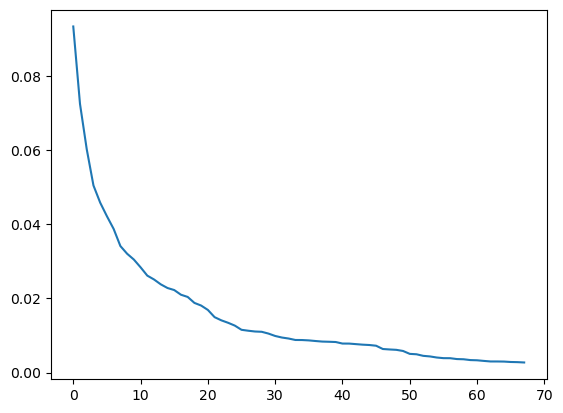

In [219]:
plt.plot(mses[3:])
plt.show()

In [ ]:
# np.save('dataset_i', dataset[i])

In [201]:
dataset[i].shape

torch.Size([3, 213, 321])

In [202]:
i

1304

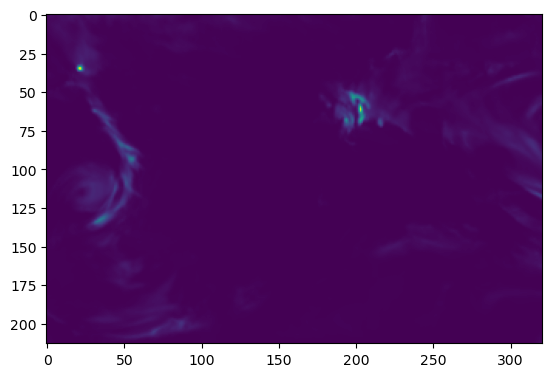

In [203]:
plt.imshow(dataset[i][1,:,:])
plt.show()

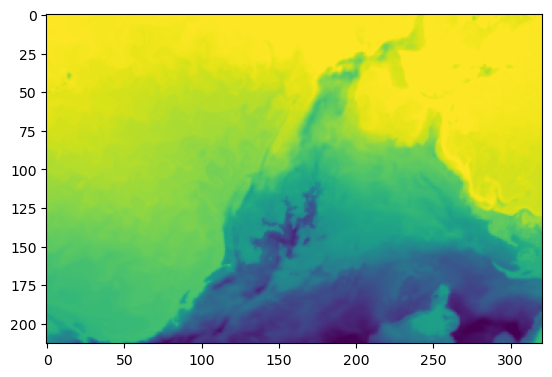

In [220]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(dataset[i][0,:,:], vmax=300,vmin=235)
plt.show()

In [162]:
# np.save('out_i', inv(0,out.detach()[:,0,:,:], means, stds).cpu().numpy())

In [206]:
model.eval()
hr_output_sample = model(hr_test.cuda())

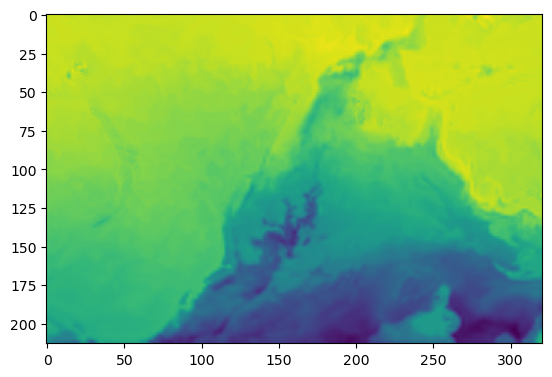

In [221]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(inv(0,hr_output_sample.detach()[:,0,:,:], means, stds).cpu()[0, :, :])
plt.show()

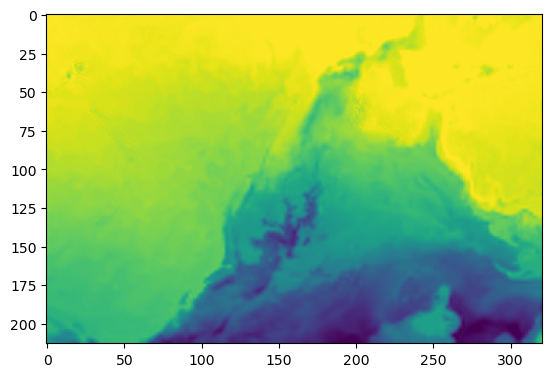

In [222]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(inv(0,best_out.detach()[:,0,:,:], means, stds).cpu()[0, :, :], vmax=300,vmin=235)
plt.show()

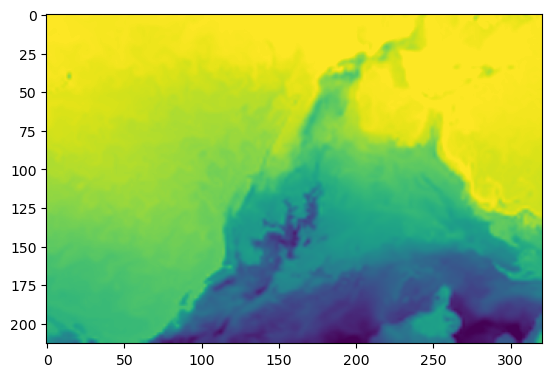

In [223]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(inv(0,hr_test.detach()[:,0,:,:], means, stds).cpu()[0, :, :], vmax=300,vmin=235)
plt.show()

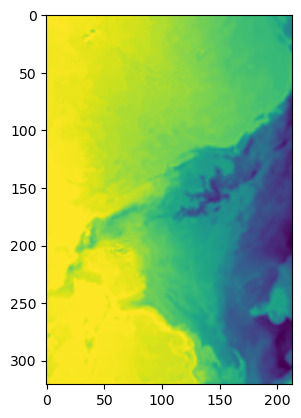

In [212]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(inv(0,out.detach()[:,0,:,:], means, stds).cpu()[0, :, :], vmax=300,vmin=235)
plt.show()

In [213]:
# np.save('hr_i', inv(0,hr[:,0,:,:], means, stds).cpu().numpy())

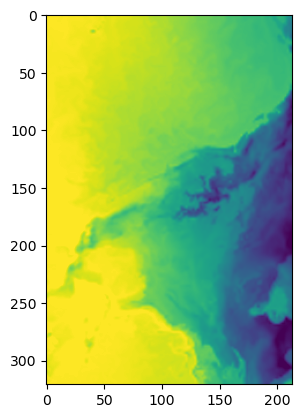

In [214]:
fig, ax = plt.subplots(dpi=100)
ax.imshow(inv(0,hr[:,0,:,:], means, stds).cpu()[0, :, :], vmax=300,vmin=235)
plt.show()